In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 37.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.1
    Uninstalling pyarrow-19.0.1:
      Successfully uninstalled pyarrow-19.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.1.

In [3]:
# !pip install torchmetrics[image]

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from datasets import load_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from torchvision import transforms
from torchmetrics.functional import structural_similarity_index_measure as ssim

from PIL import Image

# from skimage.metrics import structural_similarity as ssim
from torchmetrics.functional import structural_similarity_index_measure as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torchmetrics.image.fid import FrechetInceptionDistance

In [5]:
dataset = load_dataset("valhalla/emoji-dataset")
print(dataset)

dataset_infos.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

data/train-00000-of-00001-38cc4fa96c139e(…):   0%|          | 0.00/139M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2749 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 2749
    })
})


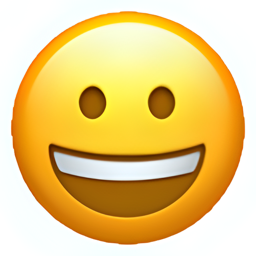

Label: grinning face


In [6]:
import io

# Select the first example
example = dataset['train'][0]

# Get the image and text
image = example['image']
text = example['text']

# Display the image and text
display(image)
print(f"Label: {text}")

In [7]:
# Split the dataset into training and validation sets
train_test_split = dataset['train'].train_test_split(test_size=0.09)

# Access the splits
train_dataset = train_test_split['train']
validation_dataset = train_test_split['test']

print("Dataset split into training and validation sets.")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")

Dataset split into training and validation sets.
Training dataset size: 2501
Validation dataset size: 248


In [81]:
class Quantize(nn.Module):
    def __init__(self, dim, n_embed, decay=0.99, eps=1e-5):
        super().__init__()

        self.dim = dim
        self.n_embed = n_embed
        self.decay = decay
        self.eps = eps

        embed = torch.randn(dim, n_embed)
        self.register_buffer("embed", embed)
        self.register_buffer("cluster_size", torch.zeros(n_embed))
        self.register_buffer("embed_avg", embed.clone())

    def forward(self, input):
        # print("inside Quantize")
        flatten = input.reshape(-1, self.dim)
        dist = (
            flatten.pow(2).sum(1, keepdim=True)
            - 2 * flatten @ self.embed
            + self.embed.pow(2).sum(0, keepdim=True)
        )
        _, embed_ind = (-dist).max(1)
        embed_onehot = F.one_hot(embed_ind, self.n_embed).type(flatten.dtype)
        # print("embed_onehot:", embed_onehot.argmax(dim=-1))
        embed_ind = embed_ind.view(*input.shape[:-1])
        quantize = self.embed_code(embed_ind)
        # print("inside Quantize | quantize:", quantize.shape)
        # print("quantize:", quantize)

        if self.training:
            embed_onehot_sum = embed_onehot.sum(0)
            embed_sum = flatten.transpose(0, 1) @ embed_onehot

            # dist_fn.all_reduce(embed_onehot_sum)
            # dist_fn.all_reduce(embed_sum)

            self.cluster_size.data.mul_(self.decay).add_(
                embed_onehot_sum, alpha=1 - self.decay
            )
            self.embed_avg.data.mul_(self.decay).add_(embed_sum, alpha=1 - self.decay)
            n = self.cluster_size.sum()
            cluster_size = (
                (self.cluster_size + self.eps) / (n + self.n_embed * self.eps) * n
            )
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(0)
            self.embed.data.copy_(embed_normalized)

        # print("shapes in normal:", quantize.shape, input.shape, embed_ind.shape)
        diff = (quantize.detach() - input).pow(2).mean()
        quantize = input + (quantize - input).detach()

        return quantize, diff, embed_ind

    def custom_access(self, embed_ind):
        quantize = self.embed_code(embed_ind)
        # print("shapes in custom_access:", quantize.shape, embed_ind.shape)
        diff = (quantize.detach() - embed_ind).pow(2).mean()
        # quantize = input + (quantize - input).detach()

        return quantize, diff, embed_ind

    def embed_code(self, embed_id):
        # print("shapes inside embed_code:", embed_id.shape)
        return F.embedding(embed_id, self.embed.transpose(0, 1))

In [82]:
# class ConvQuantize(nn.Module):
#     def __init__(self, embed_dim, n_embed, kernel_size=3, decay=0.99, eps=1e-5):
#         super().__init__()
#         self.embed_dim = embed_dim
#         # self.embed = nn.Parameter(torch.randn(n_embed, 32, kernel_size, kernel_size) * 0.1)
#         self.n_embed = n_embed
#         self.decay = decay
#         self.eps = eps
        
#         # Codebook = convolution kernels (n_embed, embed_dim, k, k)
#         embed = torch.randn(n_embed, embed_dim, kernel_size, kernel_size)
#         self.register_buffer("embed", embed)
#         self.register_buffer("cluster_size", torch.zeros(n_embed))
#         self.register_buffer("embed_avg", embed.clone())

#     def forward(self, z):
#         # z shape: (B, embed_dim, H, W)
#         B, C, H, W = z.shape
        
#         # Compute similarity: conv z with each kernel
#         # (B, n_embed, H, W)
#         dist = F.conv2d(z, self.embed, padding=self.embed.shape[-1]//2)

#         # Pick best code index per spatial location
#         embed_ind = dist.argmax(dim=1)  # (B,H,W)

#         # Convert to one-hot
#         embed_onehot = F.one_hot(embed_ind, self.n_embed).permute(0,3,1,2).float()

#         quantized = F.conv_transpose2d(embed_onehot, self.embed)

#         # EMA update (only in training)
#         if self.training:
#             usage = embed_onehot.sum(dim=[0,2,3])
#             kernel_sum = torch.einsum("bchw,bhw->c", z, embed_onehot.sum(0))

#         diff = (quantized.detach() - z).pow(2).mean()
#         quantized = z + (quantized - z).detach()

#         return quantized, diff, embed_ind

class ConvQuantize(nn.Module):
    def __init__(self, embed_dim, n_embed, k=3):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_embed = n_embed
        self.k = k

        # store kernels (n_embed, embed_dim, k, k)
        self.embed = nn.Parameter(torch.randn(n_embed, embed_dim, k, k))

    def forward(self, z):
        # z: (B, embed_dim, H, W)
        
        # ✅ transpose to (n_embed, embed_dim, k, k) → (out, in, k, k)
        weight = self.embed.permute(0, 1, 2, 3)  # OR self.embed.permute(1,0,2,3) depending on storage
    
        # conv similarity
        dist = F.conv2d(z, weight, padding=self.k//2)

        # pick max per spatial location
        embed_ind = dist.argmax(dim=1)

        # lookup
        quant = F.embedding(embed_ind, self.embed.view(self.n_embed, -1))
        quant = quant.view_as(z)

        return quant, embed_ind


In [83]:
class ResBlock(nn.Module):
    def __init__(self, in_channel, channel):
        super().__init__()

        self.conv = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channel, channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, in_channel, 1),
        )

    def forward(self, input):
        out = self.conv(input)
        out += input

        return out

In [84]:
class Encoder(nn.Module):
    def __init__(self, in_channel, channel, n_res_block, n_res_channel, stride):
        super().__init__()

        if stride == 4:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel, channel, 3, padding=1),
            ]

        elif stride == 2:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 3, padding=1),
            ]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)

In [85]:
class Decoder(nn.Module):
    def __init__(
        self, in_channel, out_channel, channel, n_res_block, n_res_channel, stride
    ):
        super().__init__()

        blocks = [nn.Conv2d(in_channel, channel, 3, padding=1)]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        if stride == 4:
            blocks.extend(
                [
                    nn.ConvTranspose2d(channel, channel // 2, 4, stride=2, padding=1),
                    nn.ReLU(inplace=True),
                    nn.ConvTranspose2d(
                        channel // 2, out_channel, 4, stride=2, padding=1
                    ),
                ]
            )

        elif stride == 2:
            blocks.append(
                nn.ConvTranspose2d(channel, out_channel, 4, stride=2, padding=1)
            )

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)

In [102]:
class VQVAE(nn.Module):
    def __init__(
        self,
        in_channel=3,
        channel=128,
        n_res_block=2,
        n_res_channel=32,
        embed_dim=64,
        n_embed=512,
        decay=0.99,
    ):
        super().__init__()

        self.enc_b = Encoder(in_channel, channel, n_res_block, n_res_channel, stride=4)
        self.enc_t = Encoder(channel, channel, n_res_block, n_res_channel, stride=2)
        self.quantize_conv_t = nn.Conv2d(channel, embed_dim, 1)
        self.quantize_t = Quantize(embed_dim, n_embed)
        # self.quantize_t = ConvQuantize(embed_dim, n_embed, k=3)
        self.dec_t = Decoder(
            embed_dim, embed_dim, channel, n_res_block, n_res_channel, stride=2
        )
        self.quantize_conv_b = nn.Conv2d(embed_dim + channel, embed_dim, 1)
        self.quantize_b = Quantize(embed_dim, n_embed)
        # self.quantize_b = ConvQuantize(embed_dim, n_embed, k=3)
        self.upsample_t = nn.ConvTranspose2d(
            embed_dim, embed_dim, 4, stride=2, padding=1
        )
        self.dec = Decoder(
            embed_dim + embed_dim,
            in_channel,
            channel,
            n_res_block,
            n_res_channel,
            stride=4,
        )

    def forward(self, input, custom_input=None):
        if (custom_input is None):
            quant_t, quant_b, diff, _, _ = self.encode(input)
        else:
            print("shape of quant_t | custom_input | in forward pass:", input.shape, custom_input.shape)
            quant_t, quant_b, diff, _, _ = self.encode(input, custom_input)
        dec = self.decode(quant_t, quant_b)

        return dec, diff

    def encode(self, input, custom_input=None):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)
        # print("shape of input, enc_b, enc_t:", input.shape, enc_b.shape, enc_t.shape)

        quant_t = self.quantize_conv_t(enc_t).permute(0, 2, 3, 1)
        # print("shape of quant_t:", quant_t.shape)

        if (custom_input is None):
            # print("shape of quant_t | custom_input is None:", quant_t.shape)
            quant_t, diff_t, id_t = self.quantize_t(quant_t)
        else:
            print("shape of quant_t | custom_input:", custom_input.shape)
            quant_t, diff_t, id_t = self.quantize_t.custom_access(custom_input)

        # print("shape of quant_t, diff_t, id_t:", quant_t.shape, diff_t.shape, id_t.shape)
        
        # print("shape of quant_t, diff_t, id_t:", quant_t.shape, diff_t.shape, id_t.shape)
        quant_t = quant_t.permute(0, 3, 1, 2)
        diff_t = diff_t.unsqueeze(0)

        dec_t = self.dec_t(quant_t)
        # print("shape of dec_t:", dec_t.shape)
        enc_b = torch.cat([dec_t, enc_b], 1)

        quant_b = self.quantize_conv_b(enc_b).permute(0, 2, 3, 1)
        quant_b, diff_b, id_b = self.quantize_b(quant_b)
        quant_b = quant_b.permute(0, 3, 1, 2)
        diff_b = diff_b.unsqueeze(0)

        return quant_t, quant_b, diff_t + diff_b, id_t, id_b

    def decode(self, quant_t, quant_b):
        upsample_t = self.upsample_t(quant_t)
        quant = torch.cat([upsample_t, quant_b], 1)
        dec = self.dec(quant)

        return dec

    def decode_code(self, code_t, code_b):
        quant_t = self.quantize_t.embed_code(code_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        quant_b = self.quantize_b.embed_code(code_b)
        quant_b = quant_b.permute(0, 3, 1, 2)

        dec = self.decode(quant_t, quant_b)

        return dec

In [103]:
class RandomMask(object):
    """Randomly mask out parts of the image for inpainting training."""
    def __init__(self, mask_ratio=0.25):
        self.mask_ratio = mask_ratio  # e.g., 0.25 means 25% pixels masked

    def __call__(self, img):
        # img is a tensor of shape (C, H, W)
        C, H, W = img.shape
        mask = (torch.rand(1, H, W) > self.mask_ratio).float()
        masked_img = img * mask
        return masked_img  # return both masked image and mask

In [104]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    RandomMask(mask_ratio=0.25),  # add random masking
])

transform__low_res = transforms.Compose([
    transforms.Resize((16, 16)),      # Downscale to 64x64
    transforms.Resize((256, 256)),    # Upscale back to 256x256 to match output size
    transforms.ToTensor(),            # Convert to tensor
])

In [105]:
# Apply the transformations to the 'image' column of the dataset splits
# train_dataset = train_dataset.with_transform(lambda examples: {'image': [transform(img) for img in examples['image']], 'text': examples['text']})
# validation_dataset = validation_dataset.with_transform(lambda examples: {'image': [transform(img) for img in examples['image']], 'text': examples['text']})

# train_dataset = train_dataset.with_transform(lambda examples: {'image': [transform__low_res(img) for img in examples['image']], 'gt_image': [transform(img) for img in examples['image']], 'text': examples['text']})
# validation_dataset = validation_dataset.with_transform(lambda examples: {'image': [transform__low_res(img) for img in examples['image']], 'gt_image': [transform(img) for img in examples['image']], 'text': examples['text']})

train_dataset = train_dataset.with_transform(lambda examples: {'image': [transform_mask(img) for img in examples['image']], 'gt_image': [transform(img) for img in examples['image']], 'text': examples['text']})
validation_dataset = validation_dataset.with_transform(lambda examples: {'image': [transform_mask(img) for img in examples['image']], 'gt_image': [transform(img) for img in examples['image']], 'text': examples['text']})


# Display the first transformed image tensor shape and a part of its values from the training dataset to verify
first_image_tensor = train_dataset[0]['image']
print(type(first_image_tensor))
print(f"Shape of the first transformed image tensor in the training set: {first_image_tensor.shape}")
print(f"First 5x5 patch of the first channel of the first transformed image tensor in the training set:\n{first_image_tensor[0, :5, :5]}")

# Display the first transformed image tensor shape and a part of its values from the validation dataset to verify
first_image_tensor_val = validation_dataset[0]['image']
print(f"Shape of the first transformed image tensor in the validation set: {first_image_tensor_val.shape}")
print(f"First 5x5 patch of the first channel of the first transformed image tensor in the validation set:\n{first_image_tensor_val[0, :5, :5]}")

<class 'torch.Tensor'>
Shape of the first transformed image tensor in the training set: torch.Size([3, 256, 256])
First 5x5 patch of the first channel of the first transformed image tensor in the training set:
tensor([[0.9961, 0.9961, 0.9922, 0.9922, 0.0000],
        [0.9961, 0.9961, 0.9961, 0.0000, 0.9922],
        [0.9961, 0.0000, 0.0000, 0.9922, 0.9922],
        [0.0000, 0.9961, 0.9961, 0.9922, 0.9922],
        [0.9961, 0.0000, 0.0000, 0.9922, 0.9922]])
Shape of the first transformed image tensor in the validation set: torch.Size([3, 256, 256])
First 5x5 patch of the first channel of the first transformed image tensor in the validation set:
tensor([[0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 0.],
        [1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


In [106]:
batch_size = 32
learning_rate = 1e-3
num_epochs = 40

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")
print(f"Number of epochs: {num_epochs}")
print(f"Device: {device}")

Batch size: 32
Learning rate: 0.001
Number of epochs: 40
Device: cuda


In [107]:
# Create the DataLoaders for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Optionally, iterate through a single batch and print the image tensor shape for the training dataloader
for batch in train_dataloader:
    images = batch['image']
    print(f"Shape of image tensor in a training batch: {images.shape}")
    # images = batch['gt_image']
    # print(f"Shape of image tensor in a training batch: {images.shape}")
    break # Only process the first batch for verification

# Optionally, iterate through a single batch and print the image tensor shape for the validation dataloader
for batch in validation_dataloader:
    images = batch['image']
    print(f"Shape of image tensor in a validation batch: {images.shape}")
    break # Only process the first batch for verification

Shape of image tensor in a training batch: torch.Size([32, 3, 256, 256])
Shape of image tensor in a validation batch: torch.Size([32, 3, 256, 256])


In [108]:
# Instantiate the VQVAE model
# The input channel is 3 for RGB images.
# The other parameters are set based on common VQVAE architectures.
model = VQVAE(in_channel=3, channel=128, n_res_block=2, n_res_channel=32, embed_dim=64, n_embed=512)
model.to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function
# The loss will be a combination of reconstruction loss (MSE) and the VQ loss (diff from the Quantize layer)
criterion = nn.MSELoss()

print("VQVAE model, optimizer, and loss function defined.")

VQVAE model, optimizer, and loss function defined.


In [109]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    reconstruction_loss_sum = 0
    vq_loss_sum = 0

    for batch in train_dataloader: # Use the training dataloader
        images = batch['image'].to(device)
        gt_images = batch['gt_image'].to(device)

        # Forward pass
        reconstructed_images, diff = model(images)

        # Calculate losses
        reconstruction_loss = criterion(reconstructed_images, gt_images)
        # Scale the VQ loss term
        vq_loss = diff * 0.25
        # SSIM loss
        ssim_loss = 1 - ssim(reconstructed_images, gt_images)
        
        # loss = reconstruction_loss + vq_loss
        loss = vq_loss + 0.75 * reconstruction_loss
        # loss = 0.75 * (vq_loss + reconstruction_loss) + 0.25 * ssim_loss

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        reconstruction_loss_sum += reconstruction_loss.item()
        vq_loss_sum += vq_loss.item()

    avg_loss = total_loss / len(train_dataloader) # Calculate average loss over training dataloader
    avg_reconstruction_loss = reconstruction_loss_sum / len(train_dataloader)
    avg_vq_loss = vq_loss_sum / len(train_dataloader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Recon Loss: {avg_reconstruction_loss:.4f}, VQ Loss: {avg_vq_loss:.4f}")

print("Training finished.")

# shape of quant_t | custom_input | in forward pass: torch.Size([1, 1, 1, 1])
# shape of input, enc_b, enc_t: torch.Size([32, 3, 256, 256]) torch.Size([32, 128, 64, 64]) torch.Size([32, 128, 32, 32])
# shape of quant_t: torch.Size([32, 32, 32, 64])
# shape of quant_t | custom_input: torch.Size([1, 1, 1, 1])

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Epoch [1/40], Loss: 0.3644, Recon Loss: 0.1690, VQ Loss: 0.2377
Epoch [2/40], Loss: 0.7872, Recon Loss: 0.1321, VQ Loss: 0.6881
Epoch [3/40], Loss: 1.6239, Recon Loss: 0.1161, VQ Loss: 1.5368
Epoch [4/40], Loss: 2.2568, Recon Loss: 0.1077, VQ Loss: 2.1761
Epoch [5/40], Loss: 0.4444, Recon Loss: 0.1049, VQ Loss: 0.3657
Epoch [6/40], Loss: 0.2776, Recon Loss: 0.1051, VQ Loss: 0.1987
Epoch [7/40], Loss: 0.2453, Recon Loss: 0.1041, VQ Loss: 0.1672
Epoch [8/40], Loss: 0.2345, Recon Loss: 0.1034, VQ Loss: 0.1569
Epoch [9/40], Loss: 0.8564, Recon Loss: 0.1074, VQ Loss: 0.7758
Epoch [10/40], Loss: 0.2129, Recon Loss: 0.1040, VQ Loss: 0.1348
Epoch [11/40], Loss: 0.2043, Recon Loss: 0.1028, VQ Loss: 0.1272
Epoch [12/40], Loss: 0.1975, Recon Loss: 0.1027, VQ Loss: 0.1205
Epoch [13/40], Loss: 0.1951, Recon Loss: 0.1023, VQ Loss: 0.1183
Epoch [14/40], Loss: 0.2078, Recon Loss: 0.1040, VQ Loss: 0.1298
Epoch [15/40], Loss: 0.0732, Recon Loss: 0.0668, VQ Loss: 0.0231
Epoch [16/40], Loss: 0.0313, Recon

In [110]:
# Set the model to evaluation mode
model.eval()

VQVAE(
  (enc_b): Encoder(
    (blocks): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ResBlock(
        (conv): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (6): ResBlock(
        (conv): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (7): ReLU(inplace=True)
    )
  )
  (enc_t): Encoder(
    (blocks): Sequential(
      (0): Conv2d(128, 64,

In [141]:
# Get a batch of images from the validation dataloader
dataiter = iter(validation_dataloader) # Use the validation dataloader
images = next(dataiter)
gt_images = images['gt_image'].to(device)
images = images['image'].to(device)

In [142]:
# B, C, H, W = images.shape
# mask = torch.ones_like(images)

# # Define mask region (center square)
# mask_height = H // 4
# mask_width = W // 4
# y1, y2 = H//2 - mask_height//2, H//2 + mask_height//2
# x1, x2 = W//2 - mask_width//2, W//2 + mask_width//2

# mask[:, :, y1:y2, x1:x2] = 0

In [143]:
# mask[0].shape

In [144]:
# plt.imshow(mask[0].cpu().reshape(256, 256, 3))

In [145]:
masked_images = images.clone()
# masked_images[mask == 0] = 0

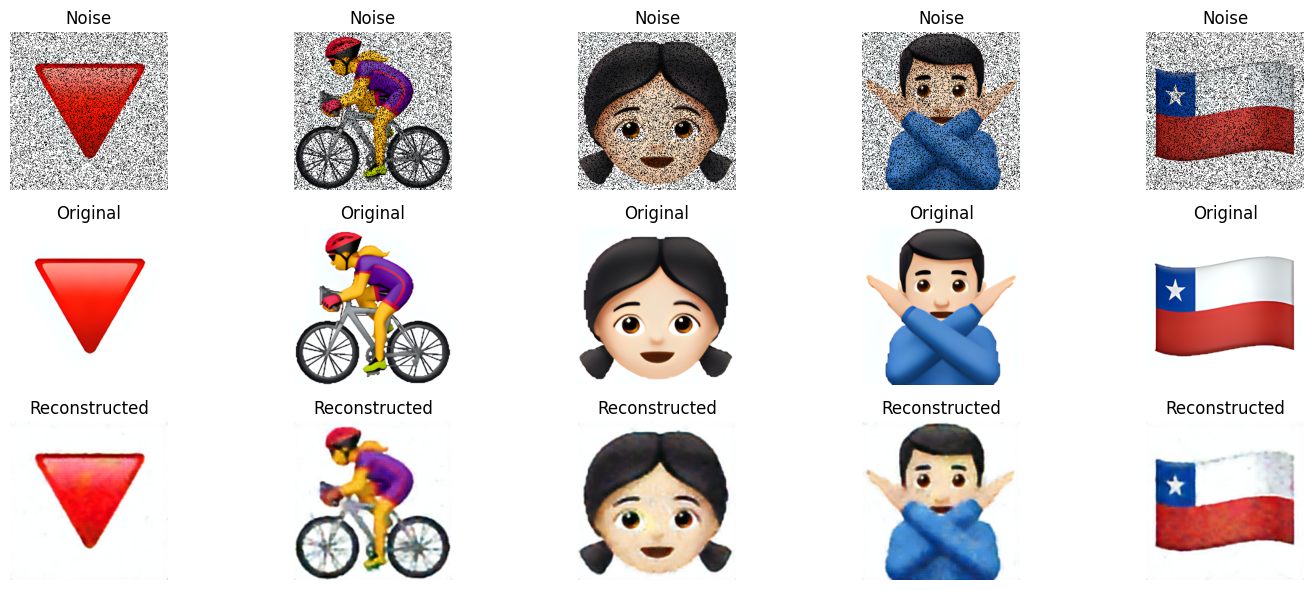

In [146]:
# Pass the images through the model to get reconstructions
with torch.no_grad():
    reconstructed_images, _ = model(masked_images)

# Convert tensors to numpy arrays for visualization
images_np = masked_images.cpu().numpy().transpose(0, 2, 3, 1)
gt_images = gt_images.cpu().numpy().transpose(0, 2, 3, 1)
reconstructed_images_np = reconstructed_images.cpu().numpy().transpose(0, 2, 3, 1)

# Clip the pixel values to the valid range [0, 1]
images_np = np.clip(images_np, 0, 1)
gt_images = np.clip(gt_images, 0, 1)
reconstructed_images_np = np.clip(reconstructed_images_np, 0, 1)

# Display original and reconstructed images
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 6))
for i in range(5):
    # Noise images
    axes[0, i].imshow(images_np[i])
    axes[0, i].set_title("Noise")
    axes[0, i].axis("off")

    # Original images
    axes[1, i].imshow(gt_images[i])
    axes[1, i].set_title("Original")
    axes[1, i].axis("off")

    # Reconstructed images
    axes[2, i].imshow(reconstructed_images_np[i])
    axes[2, i].set_title("Reconstructed")
    axes[2, i].axis("off")

plt.tight_layout()
plt.show()

In [151]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

ssim_scores = []
psnr_scores = []

# Loop through batch
for i in range(reconstructed_images_np.shape[0]):
    img_gt = gt_images[i]
    img_rec = reconstructed_images_np[i]

    # print(img_gt.shape, img_rec.shape)
    
    ssim_val = ssim(img_gt, img_rec, multichannel=True, data_range=1.0, win_size=3)
    
    psnr_val = psnr(img_gt, img_rec, data_range=1.0)

    ssim_scores.append(ssim_val)
    psnr_scores.append(psnr_val)

print(f"Average SSIM: {sum(ssim_scores)/len(ssim_scores):.4f}")
print(f"Average PSNR: {sum(psnr_scores)/len(psnr_scores):.4f} dB")

Average SSIM: 0.8882
Average PSNR: 25.3400 dB


# SSIM, PSNR, FID scores | SSIM + MSE + quant_diff

Average SSIM: 0.8403
Average PSNR: 25.1706 dB

# SSIM, PSNR, FID scores | MSE + quant_diff

Average SSIM: 0.8083
Average PSNR: 24.7731 dB

In [118]:
# ssim_scores = []
# psnr_scores = []

# images_np = gt_images

# for i in range(len(images_np)):
#     img1 = images_np[i]
#     img2 = reconstructed_images_np[i]
#     # Convert to grayscale for SSIM/PSNR computation or keep RGB with multichannel=True
#     ssim_val = ssim(img1, img2, channel_axis=-1, data_range=1.0)
#     psnr_val = psnr(img1, img2, data_range=1.0)
#     ssim_scores.append(ssim_val)
#     psnr_scores.append(psnr_val)

# mean_ssim = np.mean(ssim_scores)
# mean_psnr = np.mean(psnr_scores)

# print(f"Average SSIM: {mean_ssim:.4f}")
# print(f"Average PSNR: {mean_psnr:.4f} dB")

# # fid = FrechetInceptionDistance(feature=2048).to(device)

# # real_uint8 = (masked_images * 255).to(torch.uint8)
# # fake_uint8 = (reconstructed_images * 255).to(torch.uint8)

# # fid.update(real_uint8, real=True)
# # fid.update(fake_uint8, real=False)

# # fid_score = fid.compute().item()
# # print(f"FID Score: {fid_score:.4f}")

In [119]:
# # masked_images = torch.rot90(images, k=1, dims=(2, 3))
# masked_images = torch.tensor(reconstructed_images_np.transpose(0, 3, 1, 2)).to(device)

In [120]:
# masked_images.shape

In [121]:
# # Pass the images through the model to get reconstructions
# with torch.no_grad():
#     reconstructed_images, _ = model(masked_images)

# # Convert tensors to numpy arrays for visualization
# images_np = masked_images.cpu().numpy().transpose(0, 2, 3, 1)
# reconstructed_images_np = reconstructed_images.cpu().numpy().transpose(0, 2, 3, 1)

# # Clip the pixel values to the valid range [0, 1]
# images_np = np.clip(images_np, 0, 1)
# reconstructed_images_np = np.clip(reconstructed_images_np, 0, 1)

# # Display original and reconstructed images
# fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
# for i in range(5):
#     # Original images
#     axes[0, i].imshow(images_np[i])
#     axes[0, i].set_title("Original")
#     axes[0, i].axis("off")

#     # Reconstructed images
#     axes[1, i].imshow(reconstructed_images_np[i])
#     axes[1, i].set_title("Reconstructed")
#     axes[1, i].axis("off")

# plt.tight_layout()
# plt.show()

In [122]:
# model.quantize_t

# Morphing

In [123]:
images.shape

torch.Size([32, 3, 256, 256])

In [124]:
# Put model in eval mode
model.eval()

# Get two images (batch of 1 each)
# dataiter = iter(validation_dataloader)
img1 = images[4].unsqueeze(0).to(device)
img2 = images[3].unsqueeze(0).to(device)

In [125]:
img1.shape

torch.Size([1, 3, 256, 256])

In [126]:
with torch.no_grad():
    # Encode both images
    z_qt1, z_qb1, __, ___, ____ = model.encode(img1)       # continuous latents
    z_qt2, z_qb2, __, ___, ____ = model.encode(img2)
    
    # # Quantize them
    # z_q1, _, _ = model.quantize_t(z_e1)
    # z_q2, _, _ = model.quantize_t(z_e2)

In [127]:
z_qt1.shape, z_qb1.shape

(torch.Size([1, 64, 32, 32]), torch.Size([1, 64, 64, 64]))

In [128]:
num_steps = 10
alphas = torch.linspace(0, 1, num_steps).to(device)

In [129]:
# z_qt1 = torch.randn(1, 64, 32, 32).to(device)
# z_qb1 = torch.randn(1, 64, 64, 64).to(device)

In [130]:
morphed_images = []
with torch.no_grad():
    for alpha in alphas:
    # if True:
        # z_qt1 -= torch.randn(1, 64, 32, 32).to(device)
        # z_qb1 -= torch.randn(1, 64, 64, 64).to(device)

        # z_qt1 = torch.zeros(1, 64, 32, 32).to(device)
        # z_qb1 = torch.zeros(1, 64, 64, 64).to(device)
        # z_qt1[:, :, :, :] = 0.0
        # z_qb1[:, :, :, :] = 0.0

        # Linear interpolation in latent space
        # z_interpt = (1 - alpha) * z_qt1 + alpha * z_qt2
        # z_interpb = alpha * z_qb1 + (1 - alpha) * z_qb2

        z_interpt = (1 - alpha) * z_qt1 + alpha * z_qt2
        z_interpb = (1 - alpha) * z_qb1 + alpha * z_qb2

        # z_qt1[:, :32, :, :] = (1 - alpha) * z_qt1[:, :32, :, :] + alpha * z_qt2[:, :32, :, :]
        # z_qb1[:, :32, :, :] = (1 - alpha) * z_qb1[:, :32, :, :] + alpha * z_qb2[:, :32, :, :]

        # z_interpt = z_qt1
        # z_interpb = z_qb1
        
        # Decode to get morphed image
        recon = model.decode(z_interpt, z_interpb)
        morphed_images.append(recon.cpu())

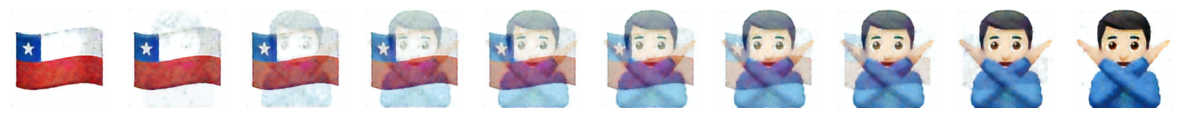

In [131]:
# Visualize morph sequence
fig, axes = plt.subplots(1, num_steps, figsize=(15, 3))
for i, ax in enumerate(axes):
    img = morphed_images[i][0].permute(1, 2, 0).clamp(0, 1)
    ax.imshow(img)
    ax.axis("off")
plt.show()

In [321]:
# morphed_images = []
# with torch.no_grad():
#     for alpha in alphas:
#         img1 = (1 - alpha) * img1 + alpha * img2
#         morphed_images.append(img1.cpu())

In [322]:
# # Visualize morph sequence
# fig, axes = plt.subplots(1, num_steps, figsize=(15, 3))
# for i, ax in enumerate(axes):
#     img = morphed_images[i][0].permute(1, 2, 0).clamp(0, 1)
#     ax.imshow(img)
#     ax.axis("off")
# plt.show()

## Accessing the VQ-VAE codebook

In [132]:
model_codebook = model.quantize_t.embed.cpu()
# .transpose(0, 1)
# model_codebook /= np.linalg.norm(model_codebook)
model_codebook.shape

torch.Size([64, 512])

In [133]:
# model_codebook[151]
# -0.1374,  0.1080,  0.0161,  ...,  0.0148, -0.0854, -0.0264

In [136]:
# # plt.imshow(model_codebook[:, :])

# plt.figure(figsize=(14, 14))
# plt.imshow(model_codebook)
# plt.axis('off')
# plt.show()

In [137]:
codebook_idx = 51
codebook_vector = model_codebook.transpose(0, 1)[codebook_idx]

codebook_vector

tensor([-0.1313, -0.0367, -0.0333, -0.1115,  0.1104,  0.0942,  0.1015, -0.0219,
         0.0383, -0.0426,  0.1077, -0.0206, -0.0057, -0.1061,  0.1163,  0.0759,
         0.1029, -0.1156,  0.0618,  0.0329, -0.0675,  0.0117, -0.0982,  0.0423,
        -0.1207, -0.1466,  0.0330, -0.0229, -0.0136, -0.0292,  0.0070, -0.0859,
         0.0451, -0.0501, -0.0849, -0.0072,  0.0801, -0.0070, -0.0715, -0.1129,
         0.0237, -0.0588, -0.0025, -0.0559, -0.0043, -0.0232,  0.0116,  0.0967,
         0.1008,  0.0613,  0.0274,  0.0231, -0.0481,  0.1005,  0.0061,  0.0252,
        -0.0222, -0.1082, -0.0722,  0.1487,  0.0338,  0.0366, -0.0314, -0.0248])

In [331]:
custom_input__vector = torch.tensor([codebook_idx]).expand(1, 32, 1).to("cuda")
# custom_input__vector = torch.zeros(1, 32, 32, 64).long().to("cuda")
custom_input__vector.shape

torch.Size([1, 32, 1])

In [332]:
custom_input = torch.zeros(32, 3, 256, 256).float().to("cuda")
# custom_input = custom_input.permute(0, 2, 3, 1)
custom_input.shape

torch.Size([32, 3, 256, 256])

In [333]:
model.quantize_t.custom_access(custom_input__vector)

shapes in custom_access: torch.Size([1, 32, 1, 64]) torch.Size([1, 32, 1])


(tensor([[[[ -42748.9688,  124344.3672, -211352.2344,  ...,    1081.6628,
              63413.6797,   50302.5703]],
 
          [[ -42748.9688,  124344.3672, -211352.2344,  ...,    1081.6628,
              63413.6797,   50302.5703]],
 
          [[ -42748.9688,  124344.3672, -211352.2344,  ...,    1081.6628,
              63413.6797,   50302.5703]],
 
          ...,
 
          [[ -42748.9688,  124344.3672, -211352.2344,  ...,    1081.6628,
              63413.6797,   50302.5703]],
 
          [[ -42748.9688,  124344.3672, -211352.2344,  ...,    1081.6628,
              63413.6797,   50302.5703]],
 
          [[ -42748.9688,  124344.3672, -211352.2344,  ...,    1081.6628,
              63413.6797,   50302.5703]]]], device='cuda:0'),
 tensor(9.4246e+09, device='cuda:0'),
 tensor([[[51],
          [51],
          [51],
          [51],
          [51],
          [51],
          [51],
          [51],
          [51],
          [51],
          [51],
          [51],
          [51],
          [

In [138]:
# model(custom_input, custom_input=custom_input__vector)

# Convolution Codebook

In [139]:
# import torch
# import random
# import numpy as np
# from torchvision import transforms
# from PIL import Image

# def random_box_mask(H, W, mask_ratio=0.25):
#     """Return mask tensor (1 for visible, 0 for hole) shape (1,H,W)."""
#     mask = torch.ones(1, H, W, dtype=torch.float32)
#     area = H * W
#     hole_area = int(area * mask_ratio)

#     # random rectangle sizes until area approx hole_area
#     for _ in range(10):
#         h = random.randint(1, H//2)
#         w = max(1, int(hole_area / h))
#         if w > W: w = W//2
#         y = random.randint(0, H - h)
#         x = random.randint(0, W - w)
#         mask[:, y:y+h, x:x+w] = 0
#         if (mask == 0).sum() >= hole_area:
#             break
#     return mask

# def random_irregular_mask(H, W, num_strokes=10, max_width=32):
#     """Create an irregular mask by drawing random strokes (numpy -> tensor)"""
#     canvas = np.ones((H, W), dtype=np.uint8) * 255
#     for _ in range(num_strokes):
#         x1, y1 = random.randint(0, W-1), random.randint(0, H-1)
#         x2, y2 = random.randint(0, W-1), random.randint(0, H-1)
#         thickness = random.randint(4, max_width)
#         # draw a filled rectangle (simple stroke)
#         xmin, xmax = min(x1, x2), max(x1, x2)
#         ymin, ymax = min(y1, y2), max(y1, y2)
#         canvas[max(0,ymin-thickness):min(H,ymax+thickness), max(0,xmin-thickness):min(W,xmax+thickness)] = 0
#     return torch.from_numpy(canvas).unsqueeze(0).float().div(255.0)  # 1,H,W float 0/1
